[![Build Status](https://travis-ci.org/Hamstard/RVMs.svg?branch=master)](https://travis-ci.org/Hamstard/RVMs)

# Tutorial on RVM Regression 

In this tutorial we play around with linear regression in form of Relevance Vector Machines (RVMs) using linear and localized kernels. And heeeere we go!

In [1]:
%matplotlib notebook
from linear_model import RelevanceVectorMachine, distribution_wrapper, GaussianFeatures, \
    FourierFeatures, repeated_regression, plot_summary
from sklearn import preprocessing
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pylab as plt

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

First things first, let's set up up the database to regress.

<IPython.core.display.Javascript object>


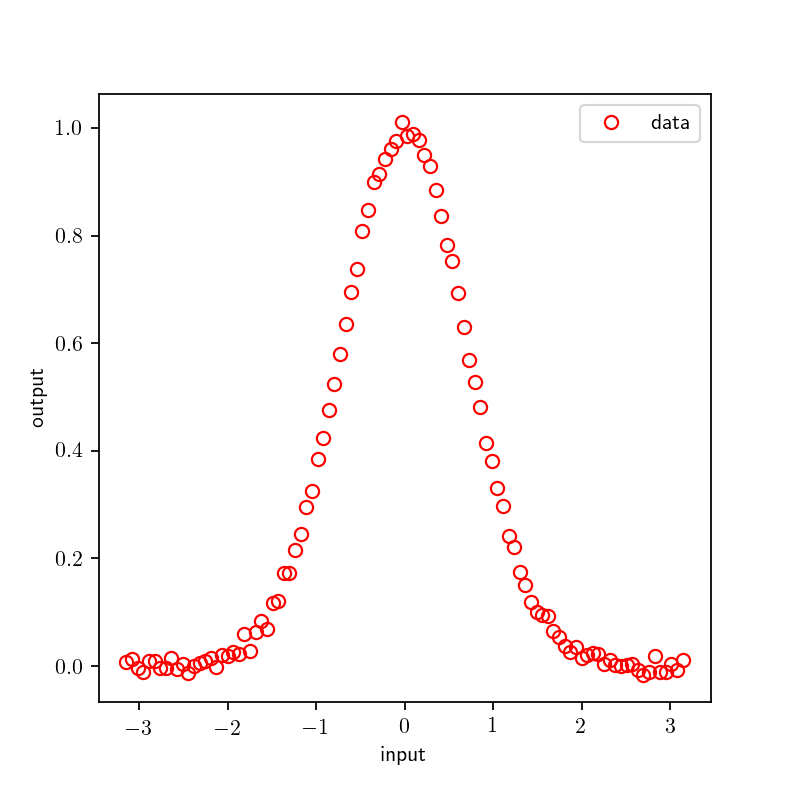

In [2]:
x = np.linspace(-np.pi,np.pi,100)
x_pred = np.linspace(-1.5*np.pi,1.5*np.pi,200)
epsilon = stats.norm(loc=0,scale=0.01)
noise = epsilon.rvs(size=x.shape[0])
t = np.exp(-x**2) + noise

fig = plt.figure(figsize=(5,5))
plt.plot(x,t,'ro',markerfacecolor="None",label="data")
plt.xlabel("input")
plt.ylabel("output")
plt.legend(loc=0)
plt.show()

## 1. Single Regression

### 1.1 Linear Kernel

Neat now let's test whether we can regress that data using a polynomial feature space.

<IPython.core.display.Javascript object>


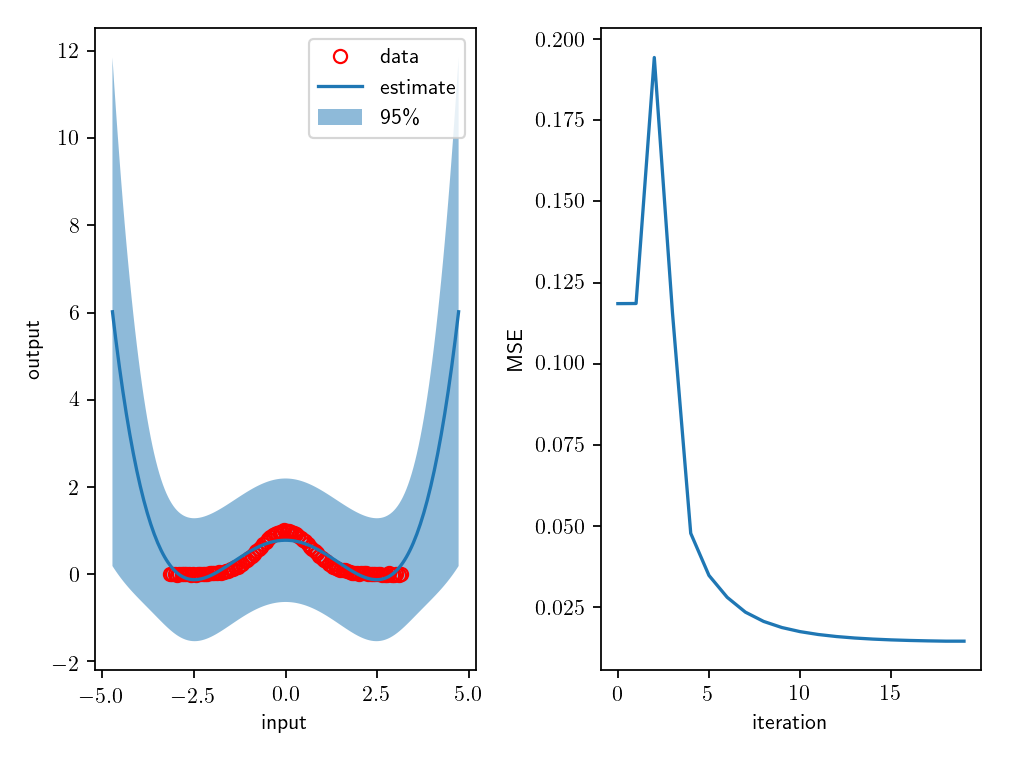

In [3]:
# choosing the feature space
k = 5
trafo = preprocessing.PolynomialFeatures(k)
X = trafo.fit_transform(x.reshape((-1,1)))

# initializing hyperparameters
init_beta = 1./ np.var(t) # (that's the default start)
init_alphas = np.ones(X.shape[1])
init_alphas[1:] = np.inf

# setting up the model regression class
model = RelevanceVectorMachine(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                               init_alphas=init_alphas)
# regress
model.fit(X,t)

# predict
X_pred = trafo.fit_transform(x_pred.reshape((-1,1)))
y, yerr = model.predict(X_pred,return_std=True)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(x,t,'ro',label="data",markerfacecolor="None")
ax.fill_between(x_pred,y-2*yerr,y+2*yerr,alpha=.5,label="95\%")
ax.plot(x_pred,y,'-',label="estimate")
plt.legend(loc=0)
ax.set_xlabel("input")
ax.set_ylabel("output")

ax1 = fig.add_subplot(122)
ax1.plot(model.mse_,'-')
ax1.set_xlabel("iteration")
ax1.set_ylabel("MSE")
plt.tight_layout()
plt.show()

### 1.2 Localized Kernel

Indeed that seemed to work. But what about a Gaussian feature space, will it be able to fit the Gaussian?

<IPython.core.display.Javascript object>


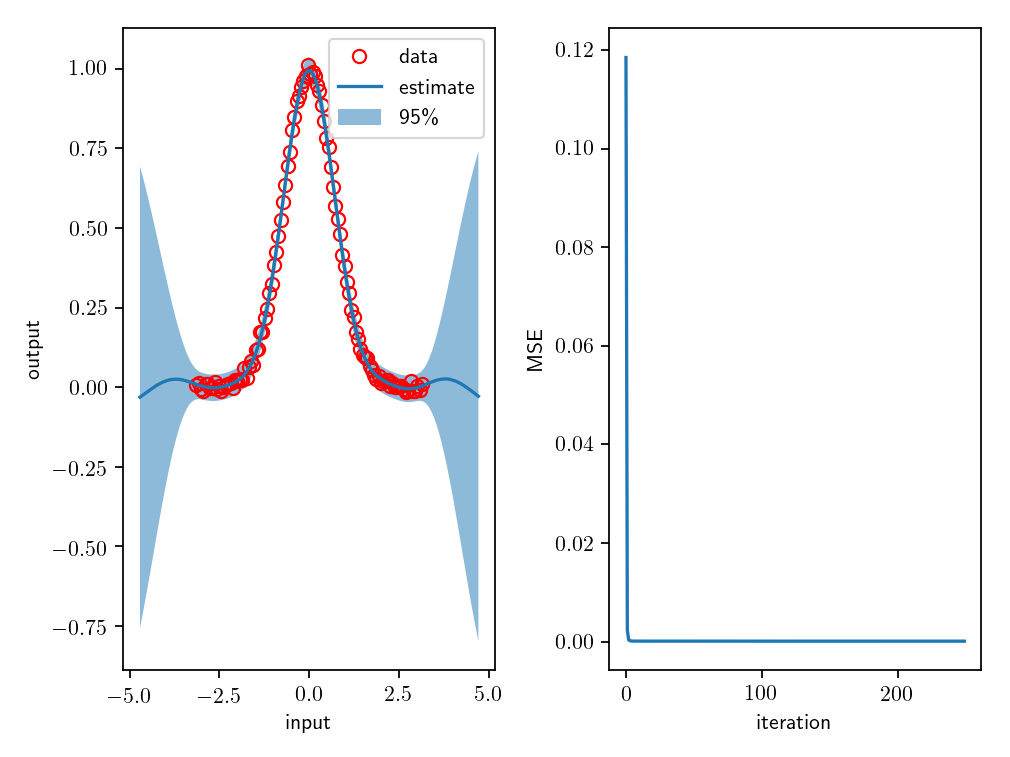

In [4]:
# choosing the feature space
trafo = GaussianFeatures(k=30,mu0=-3,dmu=.2)
X = trafo.fit_transform(x.reshape((-1,1)))

# initializing hyperparameters
init_beta = 1./ np.var(t) # (that's the default start)
init_alphas = np.ones(X.shape[1])
init_alphas[1:] = np.inf

# setting up the model regression class
model = RelevanceVectorMachine(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                               init_alphas=init_alphas)
# regress
model.fit(X,t)

# predict
X_pred = trafo.fit_transform(x_pred.reshape((-1,1)))
y, yerr = model.predict(X_pred,return_std=True)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(x,t,'ro',label="data",markerfacecolor="None")
ax.fill_between(x_pred,y-2*yerr,y+2*yerr,alpha=.5,label="95\%")
ax.plot(x_pred,y,'-',label="estimate")
plt.legend(loc=0)
ax.set_xlabel("input")
ax.set_ylabel("output")

ax1 = fig.add_subplot(122)
ax1.plot(model.mse_,'-')
ax1.set_xlabel("iteration")
ax1.set_ylabel("MSE")
plt.tight_layout()
plt.show()

## 2. Repeated Regressions

Indeed using a Gaussian basis set, for some mysterious reason, gave a closer estimate to the real data with tighter confidence intervals. Now let's do the same again for both kernels but multiple times initializing the hyperparmaeters such that we sample them from distributions as well.

### 2.1 Linear Kernel

<IPython.core.display.Javascript object>


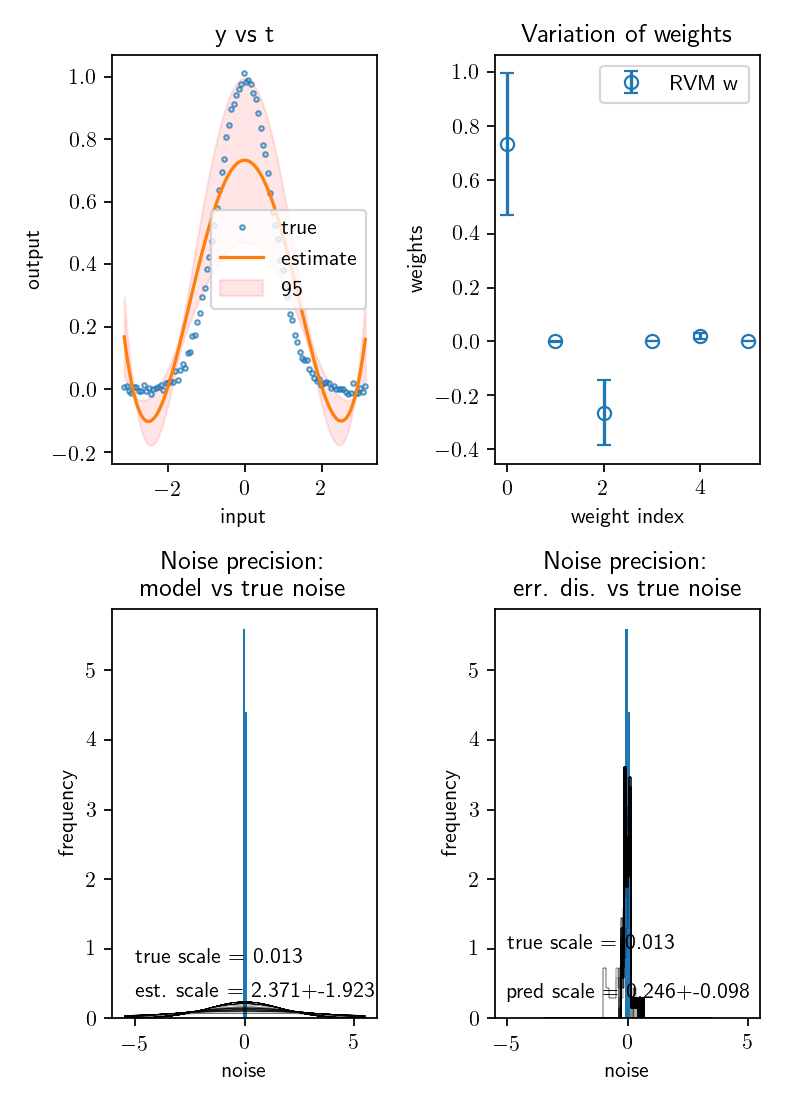

<IPython.core.display.Javascript object>


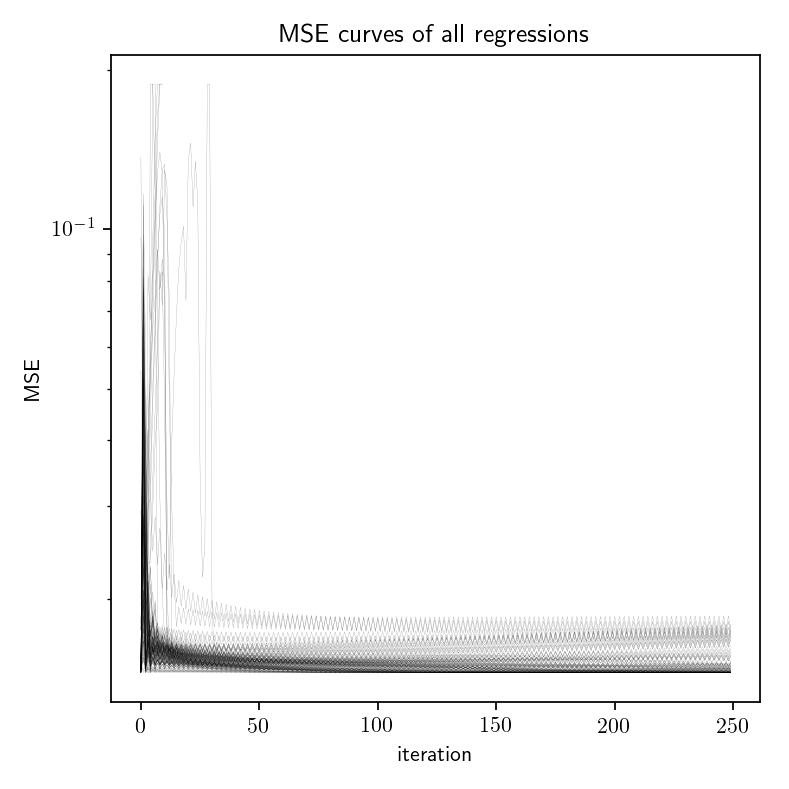

In [7]:
# choosing the feature space
k = 5
trafo = preprocessing.PolynomialFeatures(k)
X = trafo.fit_transform(x.reshape((-1,1)))
base_trafo = trafo.fit_transform

# initializing hyperparameters using callable distributions giving new hyperparameters
# with every call (useful for repeated regression)
init_beta = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
init_alphas = distribution_wrapper(stats.halfnorm(scale=1),single=False)

model_type = RelevanceVectorMachine
model_kwargs = dict(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                       init_alphas=init_alphas,fit_intercept=False)

Nruns = 100
runtimes, coefs, models = repeated_regression(x,base_trafo,model_type,t=t,
                                              model_kwargs=model_kwargs,Nruns=Nruns,
                                              return_coefs=True,return_models=True)
plot_summary(models,noise,x,t,X,coefs,base_trafo)

### 2.2 Localized kernel

<IPython.core.display.Javascript object>


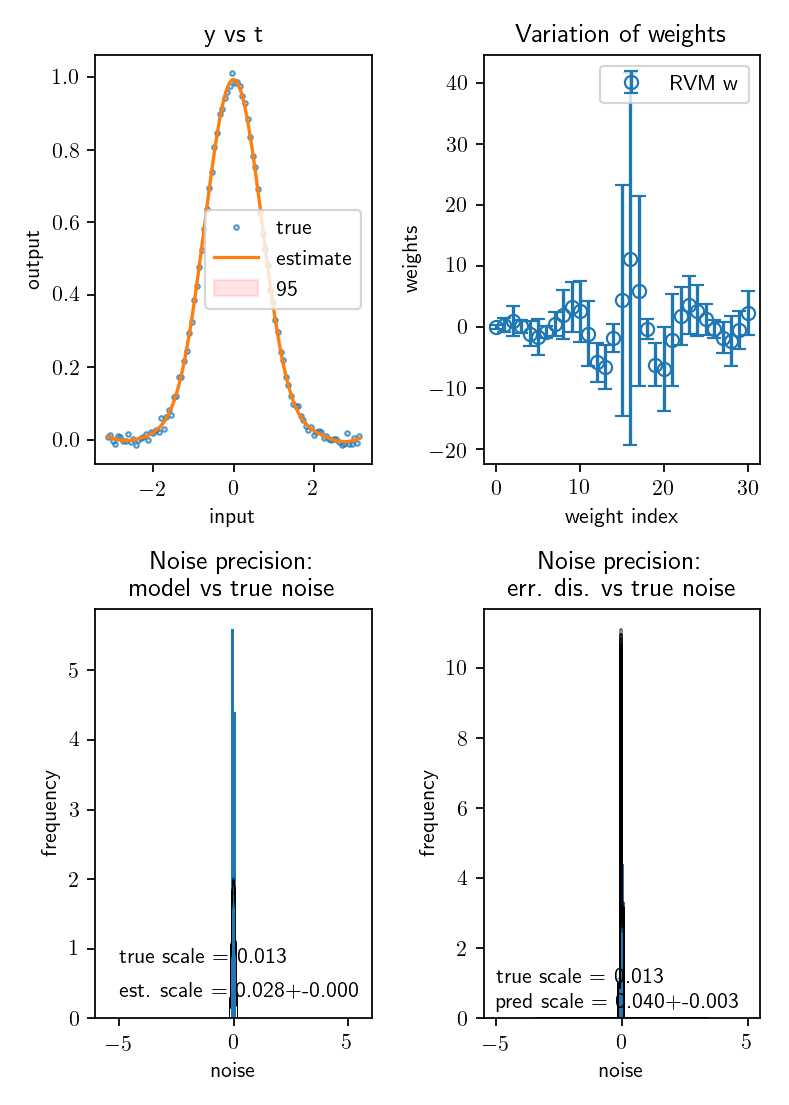

<IPython.core.display.Javascript object>


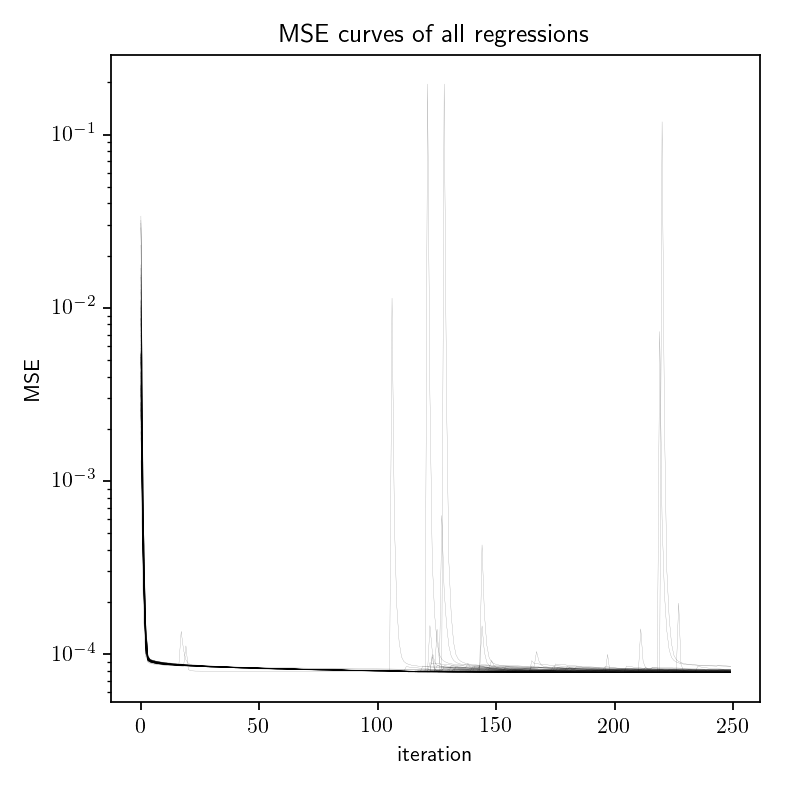

In [10]:
# choosing the feature space
trafo = GaussianFeatures(k=30,mu0=-3,dmu=.2)
base_trafo = trafo.fit_transform

# initializing hyperparameters using callable distributions giving new hyperparameters
# with every call (useful for repeated regression)
init_beta = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
init_alphas = distribution_wrapper(stats.halfnorm(scale=1),single=False)

model_type = RelevanceVectorMachine
model_kwargs = dict(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                       init_alphas=init_alphas,fit_intercept=False)

Nruns = 100
runtimes, coefs, models = repeated_regression(x,base_trafo,model_type,t=t,
                                              model_kwargs=model_kwargs,Nruns=Nruns,
                                              return_coefs=True,return_models=True)
X = base_trafo(x.reshape((-1,1)))
plot_summary(models,noise,x,t,X,coefs,base_trafo)

Excellent, that seemed to work and the Gaussians in the basis set near the true Gaussian in our data also seemed to receive the largest weights. Neat!